# RSNA-Model Training

In this notebook, we apply transfer learing to build a baseline model, which has six outputs with each corresponding to one of the labels: epidural, intraparenchymal, intraventricular, subarachnoid, subdural, any.

The pre-trained model used is a weakly-supervised ResNeXt-101 32x8d (https://github.com/facebookresearch/WSL-Images). It takes about 5 hours to make one pass of the entire dataset.

In [1]:
import os
import time
import copy

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from albumentations import Compose, ShiftScaleRotate, Resize, CenterCrop, HorizontalFlip, RandomBrightnessContrast
from albumentations.pytorch import ToTensor

In [2]:
import tensorflow as tf

import torch
import torch.optim as optim
from torch.utils.data import Dataset

In [3]:
img_dir = "stage_1_train_images_npy"

In [4]:
data_table = pd.read_pickle('rsna_data_table.pkl') 
train_table = pd.read_pickle('rsna_train_table.pkl')
valid_table = pd.read_pickle('rsna_valid_table.pkl')

In [5]:
data_table.columns

Index(['any', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural'],
      dtype='object')

## Create dataset, transform, and dataloader

In [6]:
class RSNA_dataset(Dataset):
    def __init__(self, img_dir, data_table, use_labels = False, transform=None):
        
        self.img_dir = img_dir
        self.data_table = data_table
        self.use_labels = use_labels
        self.transform = transform

    def __len__(self):
        
        return len(self.data_table)

    def __getitem__(self, idx):
                
        img_file = os.path.join(img_dir,"ID_"+self.data_table.index[idx]+".npy")
        img = np.load(img_file)   
        
        if self.transform:       
            
            img = np.dstack([img]*3)
            augmented = self.transform(image=img)
            img = augmented['image']   
            
        if self.use_labels:
            
            labels = torch.tensor(
                self.data_table.iloc[idx])
            
            #for training
            return {'image': img, 'labels': labels}    
        
        else:
            #for inferencing
            return {'image': img}
        

In [7]:
transform_train = Compose([Resize(200, 200),
                           HorizontalFlip(),
                           RandomBrightnessContrast(),
                           ShiftScaleRotate(),
                           ToTensor()
                          ])

transform_valid= Compose([Resize(200, 200),
                         ToTensor()
                        ])

In [8]:
train_data = RSNA_dataset(img_dir, train_table, use_labels = True, transform = transform_train)
valid_data = RSNA_dataset(img_dir, valid_table, use_labels = True, transform = transform_valid)

In [9]:
n_classes = 6
n_epochs = 3
batch_size = 8

image_datasets = {'train': train_data, 'valid' : valid_data }

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers = 4)
              for x in ['train', 'valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

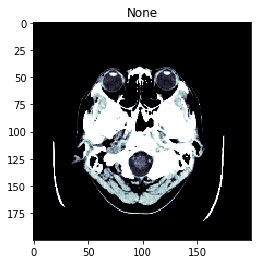

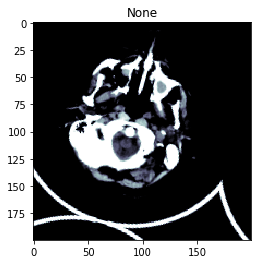

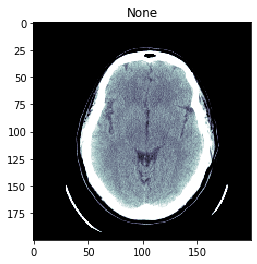

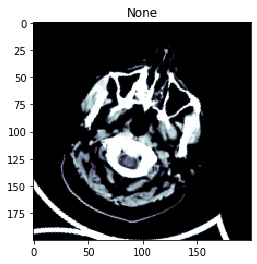

In [10]:
# Look at some training images
inputs = next(iter(dataloaders['train']))

class_names = data_table.columns

for i in range(0, 4):
     
    img = np.transpose(inputs['image'][i].numpy(), (1,2,0))[:,:,0]
    
    diagnosis = inputs['labels'][i]

    title = "None"
    for i in range(0, len(class_names)):
        if diagnosis[i] == 1:
            if title == "None":
                title = class_names[i]
            else:
                title = title + " AND " + class_names[i]
                
                
    plt.imshow(img, cmap="bone")
    plt.title(title)
    plt.pause(0.001)       

## Build model

In [11]:
# Model

device = torch.device("cuda:0")
print(device)
model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
model.fc = torch.nn.Linear(2048, n_classes)

model.to(device)

# Criterion of choice for multi-label problems
criterion = torch.nn.BCEWithLogitsLoss()

plist = [{'params': model.parameters(), 'lr': 2e-5}]
optimizer = optim.Adam(plist, lr=2e-5)

cuda:0


Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_master


## Write the training loop

In [12]:
def train_model(model, criterion, optimizer, num_epochs=n_epochs):
    
    since = time.time()

    best_loss = 100
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            
            num_samples = 0
            
            # Iterate over data.
            for step, inputs in enumerate(dataloaders[phase]):
                
                img = inputs['image']
                labels = inputs ['labels']
                
                img = img.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.float)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(img)                 
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics                   
                num_samples += img.size(0) #equal to the number of images in one batch
                
                running_loss += loss.item()*img.size(0) #loss is averaged to batch size, 
                #multiply with batch size to get total loss of current batch
                
                if num_samples%1000 == 0:
                    print('Samples {} - {} Loss: {:.4f} '.format(num_samples, phase, running_loss/num_samples))
                
                #print(running_loss)               
                
            epoch_loss = running_loss / dataset_sizes[phase]          

            print('{} Loss: {:.4f} '.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'valid' and epoch_loss< best_loss:
                best_loss = epoch_loss
        
        if epoch == 0:
            torch.save(model.state_dict(), "resnet_one_epoches.pth")
        if epoch == 1:
            torch.save(model.state_dict(), "resnet_two_epoches.pth")
        if epoch == 2:
            torch.save(model.state_dict(), "resnet_three_epoches.pth")    

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    return model

In [13]:
model = train_model(model, criterion, optimizer, num_epochs=n_epochs)

Epoch 0/2
----------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Samples 1000 - train Loss: 0.2534 
Samples 2000 - train Loss: 0.2220 
Samples 3000 - train Loss: 0.2072 
Samples 4000 - train Loss: 0.1996 
Samples 5000 - train Loss: 0.1939 
Samples 6000 - train Loss: 0.1860 
Samples 7000 - train Loss: 0.1800 
Samples 8000 - train Loss: 0.1744 
Samples 9000 - train Loss: 0.1707 
Samples 10000 - train Loss: 0.1682 
Samples 11000 - train Loss: 0.1652 
Samples 12000 - train Loss: 0.1626 
Samples 13000 - train Loss: 0.1601 
Samples 14000 - train Loss: 0.1575 
Samples 15000 - train Loss: 0.1557 
Samples 16000 - train Loss: 0.1546 
Samples 17000 - train Loss: 0.1529 
Samples 18000 - train Loss: 0.1514 
Samples 19000 - train Loss: 0.1507 
Samples 20000 - train Loss: 0.1495 
Samples 21000 - train Loss: 0.1479 
Samples 22000 - train Loss: 0.1460 
Samples 23000 - train Loss: 0.1451 
Samples 24000 - train Loss: 0.1445 
Samples 25000 - train Loss: 0.1436 
Samples 26000 - train Loss: 0.1427 
Samples 27000 - train Loss: 0.1422 
Samples 28000 - train Loss: 0.1415 
S

Samples 226000 - train Loss: 0.1045 
Samples 227000 - train Loss: 0.1044 
Samples 228000 - train Loss: 0.1044 
Samples 229000 - train Loss: 0.1043 
Samples 230000 - train Loss: 0.1043 
Samples 231000 - train Loss: 0.1042 
Samples 232000 - train Loss: 0.1042 
Samples 233000 - train Loss: 0.1041 
Samples 234000 - train Loss: 0.1040 
Samples 235000 - train Loss: 0.1040 
Samples 236000 - train Loss: 0.1040 
Samples 237000 - train Loss: 0.1039 
Samples 238000 - train Loss: 0.1038 
Samples 239000 - train Loss: 0.1038 
Samples 240000 - train Loss: 0.1037 
Samples 241000 - train Loss: 0.1036 
Samples 242000 - train Loss: 0.1036 
Samples 243000 - train Loss: 0.1035 
Samples 244000 - train Loss: 0.1034 
Samples 245000 - train Loss: 0.1034 
Samples 246000 - train Loss: 0.1034 
Samples 247000 - train Loss: 0.1033 
Samples 248000 - train Loss: 0.1032 
Samples 249000 - train Loss: 0.1032 
Samples 250000 - train Loss: 0.1031 
Samples 251000 - train Loss: 0.1030 
Samples 252000 - train Loss: 0.1030 
S

Samples 448000 - train Loss: 0.0956 
Samples 449000 - train Loss: 0.0956 
Samples 450000 - train Loss: 0.0956 
Samples 451000 - train Loss: 0.0955 
Samples 452000 - train Loss: 0.0955 
Samples 453000 - train Loss: 0.0955 
Samples 454000 - train Loss: 0.0954 
Samples 455000 - train Loss: 0.0954 
Samples 456000 - train Loss: 0.0954 
Samples 457000 - train Loss: 0.0954 
Samples 458000 - train Loss: 0.0954 
Samples 459000 - train Loss: 0.0954 
Samples 460000 - train Loss: 0.0954 
Samples 461000 - train Loss: 0.0953 
Samples 462000 - train Loss: 0.0953 
Samples 463000 - train Loss: 0.0953 
Samples 464000 - train Loss: 0.0953 
Samples 465000 - train Loss: 0.0952 
Samples 466000 - train Loss: 0.0952 
Samples 467000 - train Loss: 0.0952 
Samples 468000 - train Loss: 0.0951 
Samples 469000 - train Loss: 0.0951 
Samples 470000 - train Loss: 0.0951 
Samples 471000 - train Loss: 0.0951 
Samples 472000 - train Loss: 0.0951 
Samples 473000 - train Loss: 0.0950 
Samples 474000 - train Loss: 0.0950 
S

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Samples 1000 - valid Loss: 0.0598 
Samples 2000 - valid Loss: 0.0602 
Samples 3000 - valid Loss: 0.0575 
Samples 4000 - valid Loss: 0.0591 
Samples 5000 - valid Loss: 0.0601 
Samples 6000 - valid Loss: 0.0591 
Samples 7000 - valid Loss: 0.0590 
Samples 8000 - valid Loss: 0.0588 
Samples 9000 - valid Loss: 0.0591 
Samples 10000 - valid Loss: 0.0592 
Samples 11000 - valid Loss: 0.0600 
Samples 12000 - valid Loss: 0.0602 
Samples 13000 - valid Loss: 0.0597 
Samples 14000 - valid Loss: 0.0596 
Samples 15000 - valid Loss: 0.0600 
Samples 16000 - valid Loss: 0.0604 
Samples 17000 - valid Loss: 0.0604 
Samples 18000 - valid Loss: 0.0603 
Samples 19000 - valid Loss: 0.0608 
Samples 20000 - valid Loss: 0.0602 
Samples 21000 - valid Loss: 0.0602 
Samples 22000 - valid Loss: 0.0604 
Samples 23000 - valid Loss: 0.0605 
Samples 24000 - valid Loss: 0.0601 
Samples 25000 - valid Loss: 0.0608 
Samples 26000 - valid Loss: 0.0611 
Samples 27000 - valid Loss: 0.0615 
Samples 28000 - valid Loss: 0.0615 
S

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Samples 1000 - train Loss: 0.0788 
Samples 2000 - train Loss: 0.0818 
Samples 3000 - train Loss: 0.0761 
Samples 4000 - train Loss: 0.0803 
Samples 5000 - train Loss: 0.0823 
Samples 6000 - train Loss: 0.0824 
Samples 7000 - train Loss: 0.0801 
Samples 8000 - train Loss: 0.0803 
Samples 9000 - train Loss: 0.0804 
Samples 10000 - train Loss: 0.0802 
Samples 11000 - train Loss: 0.0801 
Samples 12000 - train Loss: 0.0801 
Samples 13000 - train Loss: 0.0809 
Samples 14000 - train Loss: 0.0809 
Samples 15000 - train Loss: 0.0807 
Samples 16000 - train Loss: 0.0807 
Samples 17000 - train Loss: 0.0813 
Samples 18000 - train Loss: 0.0813 
Samples 19000 - train Loss: 0.0808 
Samples 20000 - train Loss: 0.0814 
Samples 21000 - train Loss: 0.0810 
Samples 22000 - train Loss: 0.0809 
Samples 23000 - train Loss: 0.0806 
Samples 24000 - train Loss: 0.0807 
Samples 25000 - train Loss: 0.0805 
Samples 26000 - train Loss: 0.0804 
Samples 27000 - train Loss: 0.0802 
Samples 28000 - train Loss: 0.0800 
S

Samples 226000 - train Loss: 0.0789 
Samples 227000 - train Loss: 0.0789 
Samples 228000 - train Loss: 0.0790 
Samples 229000 - train Loss: 0.0789 
Samples 230000 - train Loss: 0.0789 
Samples 231000 - train Loss: 0.0789 
Samples 232000 - train Loss: 0.0789 
Samples 233000 - train Loss: 0.0789 
Samples 234000 - train Loss: 0.0789 
Samples 235000 - train Loss: 0.0789 
Samples 236000 - train Loss: 0.0789 
Samples 237000 - train Loss: 0.0789 
Samples 238000 - train Loss: 0.0789 
Samples 239000 - train Loss: 0.0788 
Samples 240000 - train Loss: 0.0789 
Samples 241000 - train Loss: 0.0789 
Samples 242000 - train Loss: 0.0789 
Samples 243000 - train Loss: 0.0789 
Samples 244000 - train Loss: 0.0789 
Samples 245000 - train Loss: 0.0789 
Samples 246000 - train Loss: 0.0788 
Samples 247000 - train Loss: 0.0789 
Samples 248000 - train Loss: 0.0789 
Samples 249000 - train Loss: 0.0789 
Samples 250000 - train Loss: 0.0789 
Samples 251000 - train Loss: 0.0789 
Samples 252000 - train Loss: 0.0789 
S

Samples 448000 - train Loss: 0.0782 
Samples 449000 - train Loss: 0.0782 
Samples 450000 - train Loss: 0.0782 
Samples 451000 - train Loss: 0.0782 
Samples 452000 - train Loss: 0.0782 
Samples 453000 - train Loss: 0.0782 
Samples 454000 - train Loss: 0.0782 
Samples 455000 - train Loss: 0.0782 
Samples 456000 - train Loss: 0.0782 
Samples 457000 - train Loss: 0.0782 
Samples 458000 - train Loss: 0.0782 
Samples 459000 - train Loss: 0.0782 
Samples 460000 - train Loss: 0.0782 
Samples 461000 - train Loss: 0.0782 
Samples 462000 - train Loss: 0.0782 
Samples 463000 - train Loss: 0.0782 
Samples 464000 - train Loss: 0.0782 
Samples 465000 - train Loss: 0.0782 
Samples 466000 - train Loss: 0.0782 
Samples 467000 - train Loss: 0.0781 
Samples 468000 - train Loss: 0.0781 
Samples 469000 - train Loss: 0.0781 
Samples 470000 - train Loss: 0.0781 
Samples 471000 - train Loss: 0.0781 
Samples 472000 - train Loss: 0.0781 
Samples 473000 - train Loss: 0.0781 
Samples 474000 - train Loss: 0.0781 
S

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Samples 1000 - valid Loss: 0.0552 
Samples 2000 - valid Loss: 0.0574 
Samples 3000 - valid Loss: 0.0548 
Samples 4000 - valid Loss: 0.0566 
Samples 5000 - valid Loss: 0.0577 
Samples 6000 - valid Loss: 0.0587 
Samples 7000 - valid Loss: 0.0591 
Samples 8000 - valid Loss: 0.0587 
Samples 9000 - valid Loss: 0.0585 
Samples 10000 - valid Loss: 0.0581 
Samples 11000 - valid Loss: 0.0578 
Samples 12000 - valid Loss: 0.0578 
Samples 13000 - valid Loss: 0.0576 
Samples 14000 - valid Loss: 0.0572 
Samples 15000 - valid Loss: 0.0571 
Samples 16000 - valid Loss: 0.0571 
Samples 17000 - valid Loss: 0.0572 
Samples 18000 - valid Loss: 0.0569 
Samples 19000 - valid Loss: 0.0562 
Samples 20000 - valid Loss: 0.0564 
Samples 21000 - valid Loss: 0.0565 
Samples 22000 - valid Loss: 0.0566 
Samples 23000 - valid Loss: 0.0572 
Samples 24000 - valid Loss: 0.0575 
Samples 25000 - valid Loss: 0.0571 
Samples 26000 - valid Loss: 0.0570 
Samples 27000 - valid Loss: 0.0570 
Samples 28000 - valid Loss: 0.0570 
S

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Samples 1000 - train Loss: 0.0729 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Samples 2000 - train Loss: 0.0789 
Samples 3000 - train Loss: 0.0721 
Samples 4000 - train Loss: 0.0722 
Samples 5000 - train Loss: 0.0704 
Samples 6000 - train Loss: 0.0708 
Samples 7000 - train Loss: 0.0710 
Samples 8000 - train Loss: 0.0727 
Samples 9000 - train Loss: 0.0722 
Samples 10000 - train Loss: 0.0727 
Samples 11000 - train Loss: 0.0717 
Samples 12000 - train Loss: 0.0712 
Samples 13000 - train Loss: 0.0711 
Samples 14000 - train Loss: 0.0717 
Samples 15000 - train Loss: 0.0714 
Samples 16000 - train Loss: 0.0714 
Samples 17000 - train Loss: 0.0712 
Samples 18000 - train Loss: 0.0711 
Samples 19000 - train Loss: 0.0718 
Samples 20000 - train Loss: 0.0717 
Samples 21000 - train Loss: 0.0717 
Samples 22000 - train Loss: 0.0715 
Samples 23000 - train Loss: 0.0714 
Samples 24000 - train Loss: 0.0711 
Samples 25000 - train Loss: 0.0712 
Samples 26000 - train Loss: 0.0712 
Samples 27000 - train Loss: 0.0712 
Samples 28000 - train Loss: 0.0713 
Samples 29000 - train Loss: 0.0713 


Samples 227000 - train Loss: 0.0730 
Samples 228000 - train Loss: 0.0730 
Samples 229000 - train Loss: 0.0730 
Samples 230000 - train Loss: 0.0730 
Samples 231000 - train Loss: 0.0730 
Samples 232000 - train Loss: 0.0730 
Samples 233000 - train Loss: 0.0729 
Samples 234000 - train Loss: 0.0729 
Samples 235000 - train Loss: 0.0729 
Samples 236000 - train Loss: 0.0729 
Samples 237000 - train Loss: 0.0729 
Samples 238000 - train Loss: 0.0729 
Samples 239000 - train Loss: 0.0729 
Samples 240000 - train Loss: 0.0730 
Samples 241000 - train Loss: 0.0730 
Samples 242000 - train Loss: 0.0730 
Samples 243000 - train Loss: 0.0730 
Samples 244000 - train Loss: 0.0731 
Samples 245000 - train Loss: 0.0730 
Samples 246000 - train Loss: 0.0731 
Samples 247000 - train Loss: 0.0730 
Samples 248000 - train Loss: 0.0730 
Samples 249000 - train Loss: 0.0730 
Samples 250000 - train Loss: 0.0730 
Samples 251000 - train Loss: 0.0730 
Samples 252000 - train Loss: 0.0731 
Samples 253000 - train Loss: 0.0731 
S

Samples 449000 - train Loss: 0.0728 
Samples 450000 - train Loss: 0.0728 
Samples 451000 - train Loss: 0.0728 
Samples 452000 - train Loss: 0.0728 
Samples 453000 - train Loss: 0.0728 
Samples 454000 - train Loss: 0.0728 
Samples 455000 - train Loss: 0.0728 
Samples 456000 - train Loss: 0.0728 
Samples 457000 - train Loss: 0.0728 
Samples 458000 - train Loss: 0.0728 
Samples 459000 - train Loss: 0.0728 
Samples 460000 - train Loss: 0.0728 
Samples 461000 - train Loss: 0.0728 
Samples 462000 - train Loss: 0.0728 
Samples 463000 - train Loss: 0.0728 
Samples 464000 - train Loss: 0.0728 
Samples 465000 - train Loss: 0.0728 
Samples 466000 - train Loss: 0.0728 
Samples 467000 - train Loss: 0.0728 
Samples 468000 - train Loss: 0.0728 
Samples 469000 - train Loss: 0.0728 
Samples 470000 - train Loss: 0.0728 
Samples 471000 - train Loss: 0.0728 
Samples 472000 - train Loss: 0.0727 
Samples 473000 - train Loss: 0.0727 
Samples 474000 - train Loss: 0.0727 
Samples 475000 - train Loss: 0.0728 
S

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


Samples 1000 - valid Loss: 0.0609 
Samples 2000 - valid Loss: 0.0515 
Samples 3000 - valid Loss: 0.0523 
Samples 4000 - valid Loss: 0.0516 
Samples 5000 - valid Loss: 0.0506 
Samples 6000 - valid Loss: 0.0487 
Samples 7000 - valid Loss: 0.0484 
Samples 8000 - valid Loss: 0.0483 
Samples 9000 - valid Loss: 0.0488 
Samples 10000 - valid Loss: 0.0488 
Samples 11000 - valid Loss: 0.0499 
Samples 12000 - valid Loss: 0.0502 
Samples 13000 - valid Loss: 0.0501 
Samples 14000 - valid Loss: 0.0501 
Samples 15000 - valid Loss: 0.0499 
Samples 16000 - valid Loss: 0.0503 
Samples 17000 - valid Loss: 0.0503 
Samples 18000 - valid Loss: 0.0503 
Samples 19000 - valid Loss: 0.0499 
Samples 20000 - valid Loss: 0.0504 
Samples 21000 - valid Loss: 0.0508 
Samples 22000 - valid Loss: 0.0509 
Samples 23000 - valid Loss: 0.0506 
Samples 24000 - valid Loss: 0.0511 
Samples 25000 - valid Loss: 0.0512 
Samples 26000 - valid Loss: 0.0511 
Samples 27000 - valid Loss: 0.0510 
Samples 28000 - valid Loss: 0.0512 
S

#### Remarks: Validation loss at each epoch was 0.0624, 0.0569, 0.0518. It may still decrease further as we run more epoches.